In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization, Activation

2022-06-26 03:14:15.598660: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-26 03:14:15.598725: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
BASE_DIR = './input/utkface-new/UTKFace/'

image_paths = []
age_labels = []
gender_labels = []
race_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    if len(temp) == 4:
        age = int(temp[0])
        gender = int(temp[1])
        race = int(temp[2])
        image_paths.append(image_path)
        age_labels.append(age)
        gender_labels.append(gender)
        race_labels.append(race)

  0%|          | 0/16383 [00:00<?, ?it/s]

In [3]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['race']= image_paths, age_labels, gender_labels, race_labels
df.head()

,image,age,gender,race
0,./input/utkface-new/UTKFace/1_0_2_201612191419...,1,0,2
1,./input/utkface-new/UTKFace/30_0_0_20170117144...,30,0,0
2,./input/utkface-new/UTKFace/38_1_1_20170113001...,38,1,1
3,./input/utkface-new/UTKFace/30_0_1_20170104170...,30,0,1
4,./input/utkface-new/UTKFace/29_1_1_20170112211...,29,1,1


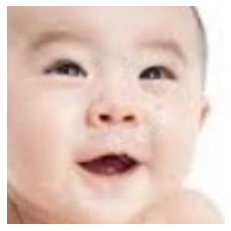

In [4]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

In [5]:
def extract_features(images):
    features = []
    i=0
    for image in tqdm(images):
        img = load_img(image, grayscale=False, color_mode = "rgb", target_size = (128,128))
        #img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        i+=1
        if i >= 5000:
            break
        
    features = np.array(features)
    # ignore this step if using RGB
    #features = features.reshape(len(features), 128, 128, 3)
    return features

In [6]:
X = extract_features(df['image'])

  0%|          | 0/16382 [00:00<?, ?it/s]

In [7]:
X.shape

(5000, 128, 128, 3)

In [8]:
X = X/255.0
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
y_race = np.array(df['race'])

In [9]:
y_race.min()

0

In [10]:
input_shape = (128, 128, 3)

In [11]:
model_transfer = VGG16(weights = 'imagenet', include_top = False, input_shape = input_shape)

2022-06-26 03:14:25.948237: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-26 03:14:25.948281: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (janPC): /proc/driver/nvidia/version does not exist
2022-06-26 03:14:25.949925: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

for layer in model_transfer.layers[:]:
    layer.trainable = False

In [13]:
inputs = Input((128,128,3))

x = model_transfer(inputs)

flatten = Flatten() (x)


dense_1 = Dense(256, activation='elu') (flatten)
dense_2 = Dense(256, activation='elu') (flatten)
dense_3 = Dense(256, activation='elu') (flatten)

batch_norm_51 = BatchNormalization()(dense_1)
batch_norm_52 = BatchNormalization()(dense_2)
batch_norm_53 = BatchNormalization()(dense_3)

dropout_1 = Dropout(0.3) (batch_norm_51)
dropout_2 = Dropout(0.3) (batch_norm_52)
dropout_3 = Dropout(0.3) (batch_norm_53)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)
output_3 = Dense(5, activation='softmax', name='race_out') (dropout_3)

model = Model(inputs=[inputs], outputs=[output_1, output_2, output_3])


model.compile(loss=['binary_crossentropy', 'mae', 'sparse_categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 4, 4, 512)    14714688    ['input_2[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['vgg16[0][0]']                  
                                                                                                  
 dense (Dense)                  (None, 256)          2097408     ['flatten[0][0]']            

In [ ]:
history = model.fit(x=X, y=[y_gender[:5000], y_age[:5000], y_race[:5000]], batch_size=32, epochs=30, validation_split=0.2,callbacks = [tensorboard_callback ])

2022-06-26 03:15:30.544889: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.


Epoch 1/30
125/125 [==============================] - ETA: 0s - loss: 16.8344 - gender_out_loss: 0.5538 - age_out_loss: 14.7939 - race_out_loss: 1.4867 - gender_out_accuracy: 0.7997 - age_out_accuracy: 0.0068 - race_out_accuracy: 0.5343

2022-06-26 03:18:30.697971: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.
2022-06-26 03:18:30.864887: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.
2022-06-26 03:18:31.036351: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.
2022-06-26 03:18:31.198797: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.


125/125 [==============================] - 181s 1s/step - loss: 16.8344 - gender_out_loss: 0.5538 - age_out_loss: 14.7939 - race_out_loss: 1.4867 - gender_out_accuracy: 0.7997 - age_out_accuracy: 0.0068 - race_out_accuracy: 0.5343 - val_loss: 33.9158 - val_gender_out_loss: 0.3439 - val_age_out_loss: 32.3532 - val_race_out_loss: 1.2187 - val_gender_out_accuracy: 0.8550 - val_age_out_accuracy: 0.0360 - val_race_out_accuracy: 0.5750
Epoch 2/30
125/125 [==============================] - 186s 1s/step - loss: 10.2695 - gender_out_loss: 0.2978 - age_out_loss: 9.1485 - race_out_loss: 0.8232 - gender_out_accuracy: 0.8775 - age_out_accuracy: 0.0052 - race_out_accuracy: 0.6917 - val_loss: 15.0441 - val_gender_out_loss: 0.4101 - val_age_out_loss: 13.2980 - val_race_out_loss: 1.3360 - val_gender_out_accuracy: 0.8190 - val_age_out_accuracy: 0.0160 - val_race_out_accuracy: 0.4930
Epoch 3/30
125/125 [==============================] - 183s 1s/step - loss: 7.3397 - gender_out_loss: 0.2391 - age_out_loss

In [ ]:
model.save("conv_model_3")